Populating the interactive namespace from numpy and matplotlib


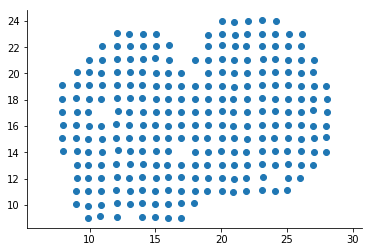

In [19]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('../MouseOB/MOB_final_results.csv', index_col=0)
ms_results = pd.read_csv('../MouseOB/MOB_MS_results.csv', index_col=0)
sample_info = pd.read_csv('../MouseOB/MOB_sample_info.csv', index_col=0)

df = pd.read_csv('../MouseOB/data/Rep11_MOB_0.csv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
df = df.loc[sample_info.index]
dfm = np.log10(df + 1)

plt.axis('equal')
plt.scatter(sample_info.x, sample_info.y);

In [20]:
X = sample_info[['x', 'y']]

In [21]:
peak = np.array([[14., 15.]])

In [22]:
def rbf_kernel_pred(X1, X2, l):
    X1sq = np.sum(np.square(X1), 1)
    X2sq = np.sum(np.square(X2), 1)
    R2 = -2. * np.dot(X1, X2.T) + (X1sq[:, None] + X2sq[None, :])
    R2 = np.clip(R2, 1e-12, np.inf)
    
    return np.exp(-R2 / (2 * l ** 2))

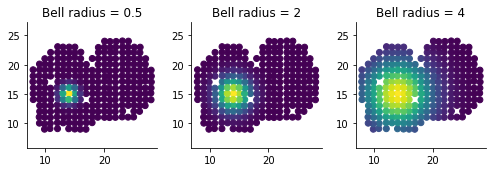

In [23]:
figsize(7, 2.5)

plt.subplot(1, 3, 1)

h = rbf_kernel_pred(peak, X, 1).T

plt.axis('equal')
plt.scatter(X.x, X.y, c=h[:, 0]);

plt.title('Bell radius = 0.5')

plt.subplot(1, 3, 2)

h = rbf_kernel_pred(peak, X, 2).T

plt.axis('equal')
plt.scatter(X.x, X.y, c=h[:,0]);

plt.title('Bell radius = 2')

plt.subplot(1, 3, 3)

h = rbf_kernel_pred(peak, X, 4).T

plt.axis('equal')
plt.scatter(X.x, X.y, c=h[:,0]);

plt.title('Bell radius = 4');

plt.tight_layout()
plt.savefig('basis_function_examples.pdf', bbox_inches='tight')

In [24]:
import SpatialDE
from scipy import stats

In [25]:
l_min, l_max = SpatialDE.base.get_l_limits(X)
l_min, l_max = l_min / 2, l_max * 2

In [26]:
sim_expr = pd.DataFrame(index=range(X.shape[0]))
ground_truth = pd.DataFrame(index=['s2', 'l'])
j = 0

s2s = 10 ** np.random.uniform(-3, 1, 100)
for l in np.logspace(np.log10(l_min), np.log10(l_max), 15):
    print(l)
    h = rbf_kernel_pred(peak, X, l)[0]
    for s2 in s2s:
        gex = h + stats.norm.rvs(scale=s2, size=(X.shape[0]))
        
        sim_expr[j] = gex
        ground_truth[j] = [s2, l]
        
        j += 1
        
ground_truth = ground_truth.T

0.20100062189
0.30982392107
0.477565000369
0.736122403946
1.13466479573
1.74898113651
2.69589311962
4.15547061125
6.40527470295
9.87314021887
15.2185350827
23.4579682786
36.1582946564
55.7346764619
85.9098635548


In [27]:
results = SpatialDE.run(X, sim_expr)
results.loc[results.pval < 1e-16, 'pval'] = 1e-16

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.11s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
  6%|▌         | 91/1500 [00:00<00:01, 905.95it/s]/Users/vale/Documents/Research projects/Ongoing/SpatialDE/Python-module/SpatialDE/base.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)
INFO:root:Model 2 of 10                             
INFO:root:Model 3 of 10                             
INFO:root:Model 4 of 10                             
INFO:root:Model 5 of 10                             
INFO:root:Model 6 of 10                             
INFO:root:Model 7 of 10                             
INFO:root:Model 8 of 10                             
INFO:root:Model 9 of 10                             
INFO:root:Model 10 of 10                            


In [28]:
results = results.sort_values('g')

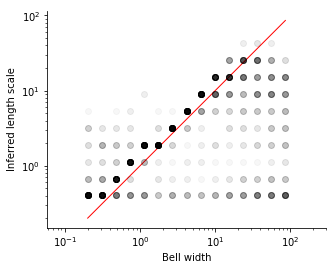

In [29]:
figsize(5, 4)
plt.loglog()
plt.plot([l_min, l_max], [l_min, l_max], c='r', lw=1, zorder=-1)
plt.scatter(ground_truth.l, results.l, alpha=0.03, c='k');
plt.axis('equal');
plt.xlabel('Bell width')
plt.ylabel('Inferred length scale');

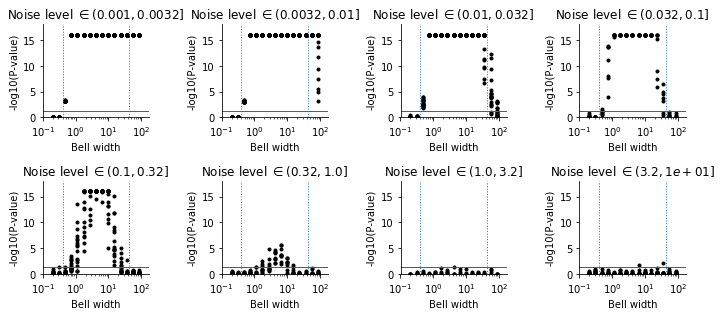

In [47]:
figsize(10, 4.5)
N = 8
irvl = np.linspace(-3, 1, N + 1)
for i in range(N):
    i0, i1 = 10 ** irvl[i], 10 ** irvl[i+1]
    gt_part = ground_truth.query('@i0 < s2 <= @i1')
    res_part= results.query('g in @gt_part.index')
    
    plt.subplot(2, N // 2, i + 1)
    
    plt.xscale('log')
    plt.scatter(gt_part.l,
                -np.log10(res_part.pval),
                c='k',
                marker='.');

    plt.axhline(-np.log10(0.05), lw=1, c='tab:red');
    plt.axvline(l_min * 2, c='tab:blue', lw=1, ls=':')
    plt.axvline(l_max / 2, c='tab:blue', lw=1, ls=':')
    
    plt.ylim(0, 18)
    plt.xlim(l_min / 2, l_max * 2)
    
    plt.title('Noise level $\in ({:0.2}, {:0.2}]$'.format(i0, i1))
    plt.xlabel('Bell width')
    plt.ylabel('-log10(P-value)')
    
plt.tight_layout()
plt.savefig('basis_function_simulation.pdf', bbox_inches='tight')